In [1]:
import pyNUISANCE as pn
rf = pn.RecordFactory()
hepdata_rec = rf.make_record({"type":"hepdata", "recordpath":"/root/software/NUISANCEMC/neutrino_data/data/T2K/CrossSection/CC0Pi_CO_TKI_2024/submission-999999"})

Welcome to JupyROOT 6.30/04


In [2]:
ana = hepdata_rec.analysis("cross_section_c")
probe_flux_count = ana.get_probe_flux(False)
probe_flux_count_density = ana.get_probe_flux(True)

pn.convert.ROOT.write_TH1("flux_for_t2k_CC0Pi_CO_TKI.root",
                          "flux_count", probe_flux_count.spectrum,False,"RECREATE")
pn.convert.ROOT.write_TH1("flux_for_t2k_CC0Pi_CO_TKI.root",
                          "flux_count_density", probe_flux_count_density.spectrum,False,"UPDATE")

print(probe_flux_count.probe_pdg)
print(probe_flux_count.source)
[ str(tgt) for tgt in ana.get_target() ]

14
/root/software/NUISANCEMC/eventinput/data/hepdata-sandbox/1722947187/HEPData-1722947187-v1/t2kflux_2020_minus250ka_nd280_runcond.yaml


['1000060120']

In [3]:
%%bash
# only generate if we haven't already
if [ ! -e events_for_t2k_CC0Pi_CO_TKI.C.root ]; then
    neut-quickstart -t C -s numu \
                -f flux_for_t2k_CC0Pi_CO_TKI.root,flux_count \
                -n 500000 --neut-param "NEUT-MDLQE" 402\
                --neut-param NEUT-MAQE 1.21 \
                --neut-param NEUT-SFCORRNNFRAC 0.33 \
                --output-card t2k_CC0Pi_CO_TKI.C.card \
                -o events_for_t2k_CC0Pi_CO_TKI.C.root &
fi
if [ ! -e events_for_t2k_CC0Pi_CO_TKI.O.root ]; then
    neut-quickstart -t O -s numu \
                -f flux_for_t2k_CC0Pi_CO_TKI.root,flux_count \
                -n 500000 --neut-param "NEUT-MDLQE" 402\
                --neut-param NEUT-MAQE 1.21 \
                --neut-param NEUT-SFCORRNNFRAC 0.33 \
                --output-card t2k_CC0Pi_CO_TKI.O.card \
                -o events_for_t2k_CC0Pi_CO_TKI.O.root &
fi
wait

In [4]:
neut_events_C = pn.EventSource("events_for_t2k_CC0Pi_CO_TKI.C.root")
if not neut_events_C:
    print("Failed to read file")

neut_events_O = pn.EventSource("events_for_t2k_CC0Pi_CO_TKI.O.root")
if not neut_events_O:
    print("Failed to read file")

nuwro_events_C = pn.EventSource("events_for_t2k_CC0Pi_CO_TKI.C.nuwro.root")
if not nuwro_events_C:
    print("Failed to read file")

nuwro_events_O = pn.EventSource("events_for_t2k_CC0Pi_CO_TKI.O.nuwro.root")
if not nuwro_events_O:
    print("Failed to read file")

In [5]:
ana = hepdata_rec.analysis("cross_section_co")
comparison_CO_neut = ana.process([neut_events_C, neut_events_O])
comparison_CO_nuwro = ana.process([nuwro_events_C, nuwro_events_O])

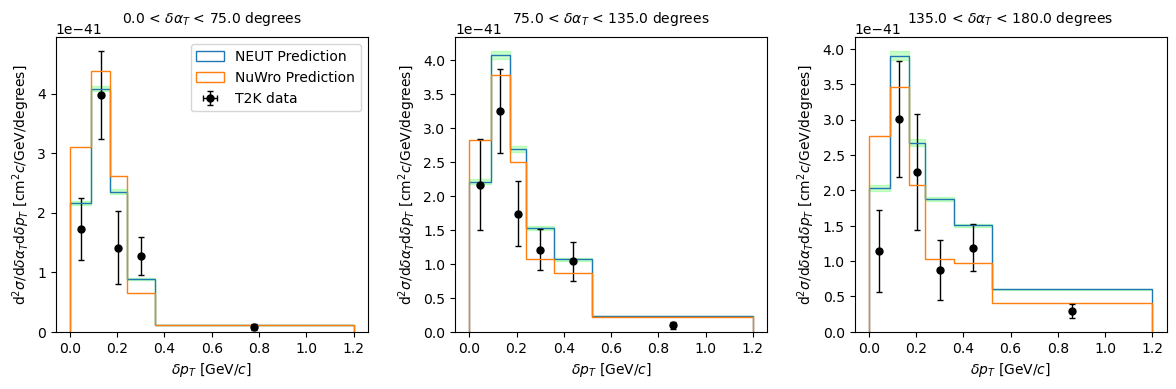

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,3, figsize=(12,4))

d_x_bin_centers = pn.Binning.get_bin_centers1D(comparison_CO_neut.data[0].project(0).binning.bins)
d_x_bin_edges = pn.Binning.get_bin_edges1D(comparison_CO_neut.data[0].project(0).binning.bins)

for i in range(len(d_x_bin_centers)):
    d_slice = comparison_CO_neut.data[0].slice(0,d_x_bin_centers[i])
    p_slice = comparison_CO_neut.predictions[0].slice(0,d_x_bin_centers[i])
    p_slice_nuwro = comparison_CO_nuwro.predictions[0].slice(0,d_x_bin_centers[i])
    
    d_slice.mpl().data_hist(plot_axis=axes[i], label="T2K data")
    p_slice.mpl().hist(histtype="step", plot_axis=axes[i], errorband_color="#0F03", label="NEUT Prediction")
    p_slice_nuwro.mpl().hist(histtype="step", plot_axis=axes[i], label="NuWro Prediction")

    x_proj_prettyname = ana.get_projections()[0].prettyname
    x_proj_unit = ana.get_projections()[0].units
    
    axes[i].text(0.5,1.05,f"{d_x_bin_edges[i]} < {x_proj_prettyname} < {d_x_bin_edges[i+1]} {x_proj_unit}",
                horizontalalignment="center",transform = axes[i].transAxes)
    
    if not i:
        axes[i].legend()

fig.tight_layout()
fig.show()

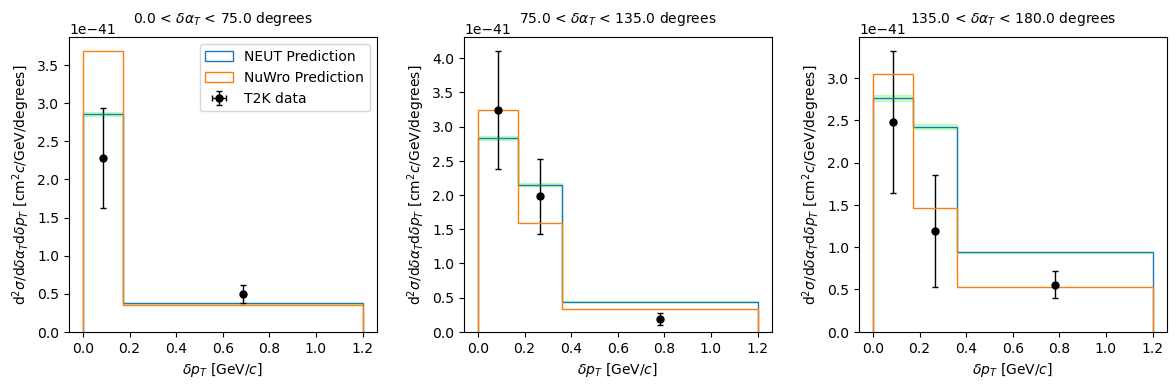

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,3, figsize=(12,4))

d_x_bin_centers = pn.Binning.get_bin_centers1D(comparison_CO_neut.data[1].project(0).binning.bins)
d_x_bin_edges = pn.Binning.get_bin_edges1D(comparison_CO_neut.data[1].project(0).binning.bins)

for i in range(len(d_x_bin_centers)):
    d_slice = comparison_CO_neut.data[1].slice(0,d_x_bin_centers[i])
    p_slice = comparison_CO_neut.predictions[1].slice(0,d_x_bin_centers[i])
    p_slice_nuwro = comparison_CO_nuwro.predictions[1].slice(0,d_x_bin_centers[i])

    d_slice.mpl().data_hist(plot_axis=axes[i], label="T2K data")
    p_slice.mpl().hist(histtype="step", errorband_color="#0F03", plot_axis=axes[i], label="NEUT Prediction")
    p_slice_nuwro.mpl().hist(histtype="step", plot_axis=axes[i], label="NuWro Prediction")

    x_proj_prettyname = ana.get_projections()[0].prettyname
    x_proj_unit = ana.get_projections()[0].units
    
    axes[i].text(0.5,1.05,f"{d_x_bin_edges[i]} < {x_proj_prettyname} < {d_x_bin_edges[i+1]} {x_proj_unit}",
                horizontalalignment="center",transform = axes[i].transAxes)
    
    if not i:
        axes[i].legend()

fig.tight_layout()
fig.show()

In [8]:
comparison_CO_neut.likelihood()

87.86557462282246

In [9]:
comparison_CO_nuwro.likelihood()

107.21967355572401

## Manual Mode

In [10]:
wf = pn.WeightCalcFactory()
neut_rw_C = wf.make(neut_events_C, {"plugin_name":"T2KReWeight", 
                      "neut_cardname": "t2k_CC0Pi_CO_TKI.C.card"})
neut_rw_O = wf.make(neut_events_O, {"plugin_name":"T2KReWeight", 
                      "neut_cardname": "t2k_CC0Pi_CO_TKI.O.card"})

 did scope guard 
 CRSPATH_ENV: /opt/neut/5.8.0/share/neut/crsdat
 Reading t2k_CC0Pi_CO_TKI.C.card as card
 ======= CONFIGURATION FOR INTERACTIONS =======
 Reading t2k_CC0Pi_CO_TKI.C.card as a card file
 Using Spectral Function for elastic events
 NECARD : INPUTTED PARAMETER 
 NECARD : CRSPATH= /opt/neut/5.8.0/share/neut/crsdat/
 NECARD : FERM   =            0
 NECARD : PAUL   =            0
 NECARD : PAUL2p2h =            0
 NECARD : NEFF   =            0
 NECARD : NUCDEXITE =            1
 NECARD : MODL   =            1
 NECARD : MODH   =            1
 NECARD : KINH   =            1
 NECARD : MODE   =            0
 NECARD : COHEPI =            2
 NECARD : DIFPI  =            0
 ********* CCQE SETTINGS ***************
 NECARD : MDLQE   =          402
 NECARD : MDLQEAF =            1
 NECARD : MDL2P2H =            2
 NECARD : NV2P2HQVAL =            1
 NECARD : MAQE    =    1.21000004    
 NECARD : AXFFALPHA =  0.230000004    
 NECARD : AXFFBETA=   1.22000003    
 NECARD : AXFFGAMMA=  

In [11]:
neut_rw_C.set_parameters({"SRCFrac_C": 0.66})
neut_rw_O.set_parameters({"SRCFrac_O": 0.66})

In [12]:
neut_evframe_C = pn.EventFrameGen(neut_events_C)
ana.add_to_framegen(neut_evframe_C)
neut_evframe_C.add_column("SF_SRC_Norm_C +1", lambda x: neut_rw_C.calc_weight(x))

neut_evframe_O = pn.EventFrameGen(neut_events_O)
ana.add_to_framegen(neut_evframe_O)
neut_evframe_O.add_column("SF_SRC_Norm_O +1", lambda x: neut_rw_O.calc_weight(x))

In [13]:
ef_c = neut_evframe_C.firstArrow(int(1E6))
ef_o = neut_evframe_O.firstArrow(int(1E6))

In [14]:
ef_c.to_pandas()

,event.number,weight.cv,fatx_per_sumw.pb_per_target.estimate,fatx_per_sumw.pb_per_nucleon.estimate,process.id,T2K_CC0Pi_CO_TKI_nu_2024_Select_C,T2K_CC0Pi_CO_TKI_nu_2024_Select_O,T2K_CC0Pi_CO_TKI_nu_2024_Project_DeltaAlphaT_deg,T2K_CC0Pi_CO_TKI_nu_2024_Project_DeltaPT_GeV_c,SF_SRC_Norm_C +1
0,0,1.0,1.963824e-01,1.636520e-02,600,0,0,3.735929e+09,3.735929e+09,1.0
1,1,1.0,9.819121e-02,8.182601e-03,200,1,0,1.562004e+02,5.026066e-01,1.0
2,2,1.0,6.546081e-02,5.455067e-03,400,0,0,7.316685e+01,4.488396e-01,1.0
3,3,1.0,4.909561e-02,4.091300e-03,600,0,0,1.776481e+02,1.215831e+00,1.0
4,4,1.0,3.927648e-02,3.273040e-03,451,0,0,3.735929e+09,3.735929e+09,1.0
...,...,...,...,...,...,...,...,...,...,...
499995,499995,1.0,3.927680e-07,3.273067e-08,200,0,0,1.137685e+02,2.087254e-01,1.0
499996,499996,1.0,3.927672e-07,3.273060e-08,200,0,0,1.015485e+02,7.654351e-02,1.0
499997,499997,1.0,3.927664e-07,3.273053e-08,400,0,0,1.763770e+02,8.307132e-01,1.0
499998,499998,1.0,3.927656e-07,3.273047e-08,402,0,0,3.735929e+09,3.735929e+09,1.0


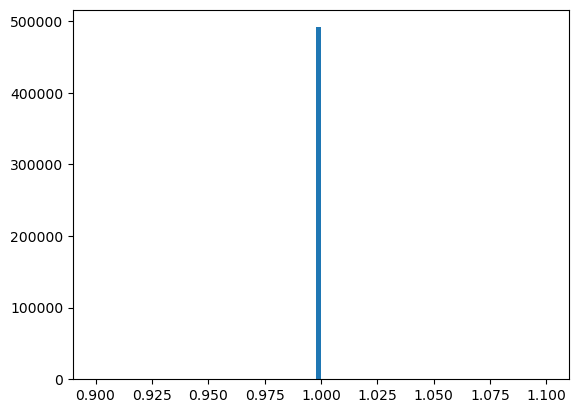

In [15]:

weighth = pn.HistFrame(pn.Binning.lin_space(0.9,1.1,100))
weighth.fill(ef_c, ["SF_SRC_Norm_C +1"], [pn.HistFrame.fill_column(0)])
weighth.mpl().hist()
plt.show()